# Распознавание именованных сущностей из Twitter с помощью LSTM

## курс "Математические методы анализа текстов"


### ФИО: Попов Николай

## Введение

### Постановка задачи

В этом задании используются рекуррентные нейронные сети для решения проблемы распознавания именованных сущностей (NER). Примерами именованных сущностей являются имена людей, названия организаций, адреса и т.д. В этом задании также используются данные twitter.

Например, чтобы найти имена и названия организаций в тексте

    Yan Goodfellow works for Google Brain

модель должна извлечь следующую последовательность:

    B-PER I-PER    O     O   B-ORG  I-ORG

где префиксы *B-* и *I-* означают начало и конец именованной сущности, *O* означает слово без тега. Такая префиксная система введена, чтобы различать последовательные именованные сущности одного типа.

Решение этого задания будет основано на нейронных сетях, а именно на Bi-Directional Long Short-Term Memory Networks (BiLSTMs). В базовой части задания также нужно будет улучшить модель при помощи необучаемого пост-процессинга, основанного на алгоритме Витерби и графической модели CRF.

### Библиотеки

Для этого задания понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Numpy](http://www.numpy.org).
 
### Данные

Все данные содержатся в папке `./data`: `./data/train.txt`, `./data/validation.txt`, `./data/test.txt`.

Скачать архив можно здесь: [ссылка на google диск](https://drive.google.com/open?id=1s1rFOFMZTBqtJuQDcIvW-8djA78iUDcx)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Texts IAD/2
!ls

/content/drive/My Drive/Colab Notebooks/Texts IAD/2
evaluation_ner.py	   __pycache__	train.txt  try_2
Popov_lab_tagging-0.ipynb  test.txt	try	   validation.txt


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Часть 1. Подготовка данных (2 балла)

### Загрузка данных

Мы будем работать с данными, которые содержат твиты с тегами именованных сущностей. Каждая строка файла содержит пару токен (слово или пунктуация) и тег, разделенные пробелом. Различные твиты разделены пустой строкой.

Функция *read_data* считывает корпус из *file_path* и возвращает два списка: один с токенами и один с соответствующими токенам тегами. Также она заменяет все ники (токены, которые начинаются на символ *@*) на токен `<USR>` и url-ы (токены, которые начинаются на *http://* или *https://*) на токен `<URL>`. 

**<font color='red'>Задание. Реализуйте функцию read_data.</font>**

In [ ]:
def read_data(file_path):
    tokens = []
    tags = []

    tokens_in_twit = []
    tags_in_twit = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.split(): #твит не закончился (строка не пустая)
                token, tag = line.strip().split(' ')
                if token.strip().startswith('http://') or token.strip().startswith('https://'):
                    token = '<URL>'
                if token.strip().startswith("@") :
                    token = '<USR>'
                tokens_in_twit.append(token)
                tags_in_twit.append(tag)
            else:               #твит закончился
                tokens.append(tokens_in_twit)
                tags.append(tags_in_twit)
                tokens_in_twit = []
                tags_in_twit = []
    
    return tokens, tags

Теперь мы можем загрузить 3 части данных:
 - *train* для тренировки модели;
 - *validation* для валидации и подбора гиперпараметров;
 - *test* для финального тестирования.

In [ ]:
train_sentences, train_tags = read_data('train.txt')
val_sentences, val_tags = read_data('validation.txt')
test_sentences, test_tags = read_data('test.txt')

Размеры наборов

In [ ]:
print(len(train_sentences), ' твитов в трейне')
print(len(val_sentences), ' твитов в валидации')
print(len(test_sentences), ' твитов в тесте')

5795  твитов в трейне
724  твитов в валидации
724  твитов в тесте


У твитов разные длины

In [ ]:
for i in range(5):
    print(len(train_sentences[i]), len(train_tags[i]))

26 26
21 21
14 14
15 15
25 25


Всегда полезно знать, с какими данными вы работаете. Выведем небольшую часть.

In [ ]:
for i in range(3):
    for token, one_tag in zip(train_sentences[i], train_tags[i]):
        print('%s\t%s' % (token, one_tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Подготовка словарей

Чтобы обучать нейронную сеть, мы будем использовать два отображения.

- {token}$\to${token id}: устанавливает соответствие между токеном и строкой в embedding матрице;
- {tag}$\to${tag id}: one hot encoding тегов.


Теперь необходимо реализовать функцию *build_dict*, которая должна возвращать словарь {token or tag}$\to${index} и контейнер, задающий обратное отображение.

**<font color='red'>Задание. Реализуйте функцию build_dict.</font>**

In [ ]:
from collections import defaultdict

def build_dict(entities, special_entities):
    """
    Args:
        entities: a list of lists of tokens or tags
        special_entities: some special tokens
        
    Returns:
        entity_to_idx : mapping to index  
        idx_to_entity : mapping from index
    """
    entity_to_idx = defaultdict(lambda: 0) #теперь для всех слов вне словаря возвращается индекс 0
    idx_to_entity = []
    
    # Create mappings from tokens to indices and vice versa
    # Add special tokens to dictionaries
    # The first special token must have index 0

    list_of_entities = [token for twit in entities for token in twit]
    unique_entities = set(list_of_entities)
    idx = 0

    for token in special_entities:
        entity_to_idx[token] = idx
        idx_to_entity.append(token)
        idx += 1

    for token in list_of_entities:
        if token in unique_entities:
            entity_to_idx[token] = idx
            idx_to_entity.append(token)
            idx += 1
            unique_entities = unique_entities - set([token])
    
    return entity_to_idx, idx_to_entity

После реализации функции *build_dict* вы можете создать словари для токенов и тегов. В нашем случае специальными токенами будут:
 - `<UNK>` токен для обозначаения слов, которых нет в словаре;
 - `<PAD>` токен для дополнения предложений одного батча до одинаковой длины.

In [ ]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = []

# Create dictionaries 
token_to_idx, idx_to_token = build_dict(train_sentences + val_sentences, special_tokens)
tag_to_idx, idx_to_tag = build_dict(train_tags, special_tags)

print(token_to_idx['<UNK>'])
print(token_to_idx['коля'])
idx_to_token[0]

0
0


'<UNK>'

Для решения проблемы неизвестных слов при тестировании использовано defaultdict(lambda: 0) - теперь для всех неизвестных слов возвращается индекс 0, по которому в свою очередь возвращается <UNK>

In [ ]:
tag_to_idx

defaultdict(<function __main__.build_dict.<locals>.<lambda>>,
            {'B-company': 5,
             'B-facility': 9,
             'B-geo-loc': 12,
             'B-movie': 16,
             'B-musicartist': 1,
             'B-other': 7,
             'B-person': 6,
             'B-product': 3,
             'B-sportsteam': 11,
             'B-tvshow': 18,
             'I-company': 14,
             'I-facility': 10,
             'I-geo-loc': 13,
             'I-movie': 17,
             'I-musicartist': 2,
             'I-other': 8,
             'I-person': 15,
             'I-product': 4,
             'I-sportsteam': 20,
             'I-tvshow': 19,
             'O': 0})

In [ ]:
vocab_size = len(token_to_idx)
n_tags = len(tag_to_idx)
print('vocab_size = {}, n_tags = {}'.format(vocab_size, n_tags))

vocab_size = 20506, n_tags = 21


### Подготовка датасета и загрузчика

Обычно нейронные сети обучаются батчами. Это означает, что каждое обновление весов нейронной сети происходит на основе нескольких последовательностей. Технической деталью является необходимость дополнить все последовательности внутри батча до одной длины. 

Для начала необходимо реализовать <<датасет>> для хранения ваших данных. Датасет должен наследоваться от стандартного pytorch класса `Dataset` и переопределять методы `__getitem__` и `__len__`. Метод `__getitem__` должен возвращать индексированную последовательность и её теги. Не забудьте про `<UNK>` токен для неизвестных слов!

**<font color='red'>Задание. Реализуйте класс TaggingDataset.</font>**

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TaggingDataset(Dataset):
    
    def __init__(self, sentences, tags, token_to_idx, tag_to_idx):
        """
        Args:
            sentences: a list of lists of tokens or tags
            tags: some special tokens
            token_to_idx: mapping from token to token indexes
            tag_to_idx: mapping from tag to tag indexes
        """
        super().__init__()
        self.sentences = sentences
        self.tags = tags
        self.token_to_idx = token_to_idx
        self.tag_to_idx = tag_to_idx
        
    def __getitem__(self, idx):
        """
        Args:
            idx : int
            
        Returns:
            sentence_idx : torch.tensor of token indexes
            tag_idx : torch.tensor of tag indexes
        """
        sentence_idx = [token_to_idx[token] for token in self.sentences[idx]]
        tag_idx = [tag_to_idx[tag] for tag in self.tags[idx]]
        return (torch.tensor(sentence_idx), torch.tensor(tag_idx))

    def __len__(self):
        return len(self.sentences)


Для того, чтобы дополнять последовательности паддингом, будем использовать параметр `collate_fn` класса `DataLoader`. Принимая последовательность пар тензоров для предложений и тегов, необходимо дополнить все последовательности до последовательности максимальной длины в батче. Используйте специальные теги `<PAD>` и `O` для дополнения.

**<font color='red'>Задание. Реализуйте класс PaddingCollator.</font>**

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class PaddingCollator:
    def __init__(self,  pad_token_id, pad_tag_id, batch_first=True):
        self.pad_token_idx = pad_token_id
        self.pad_tag_id = pad_tag_id
        self.batch_first = batch_first
        
    def __call__(self, batch):
        """
        Args:
            batch: list of tuples of torch.tensors
        
        Returns:
            new_sentences: torch.tensor
            new_tags: torch.tensor
                Both tensors have the same size 
        """

        new_sentences = []
        new_tags = []
        for (twit, tag) in batch:
            new_sentences.append(twit)
            new_tags.append(tag)
        new_sentences = pad_sequence(new_sentences, self.batch_first, self.pad_token_idx)
        new_tags = pad_sequence(new_tags, self.batch_first, self.pad_tag_id)
        return new_sentences, new_tags

Теперь всё готово, чтобы задать DataLoader. Протестируйте на примере ниже, что всё работает правильно.

In [ ]:
small_dataset = TaggingDataset(
    sentences=train_sentences[:7],
    tags=train_tags[:7],
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

small_loader = DataLoader(
    small_dataset,
    batch_size=3,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

batch_lengths = [3, 3, 1]
sequence_lengths = [26, 25, 8]
some_pad_tensor = torch.LongTensor([token_to_idx['<PAD>']] * 12)
some_outside_tensor = torch.LongTensor([[tag_to_idx['O']] * 12])

for i, (tokens_batch, tags_batch) in enumerate(small_loader):
    assert tokens_batch.dtype == torch.int64, 'tokens_batch is not LongTensor'
    assert tags_batch.dtype == torch.int64, 'tags_batch is not LongTensor'
    
    assert len(tokens_batch) == batch_lengths[i], 'wrong batch length'
    
    for one_token_sequence in tokens_batch:
        assert len(one_token_sequence) == sequence_lengths[i], 'wrong length of sequence in batch'
    
    if i == 0:
        assert torch.all(tokens_batch[2][-12:] == some_pad_tensor), "wrong padding"       
        assert torch.all(tags_batch[2][-12:] == some_outside_tensor), "wrong O tag"

**<font color='red'>Задание. В ячейке ниже задайте датасеты и загрузчики для обучающих, валидационных и тестовых данных.</font>**

In [ ]:
train_dataset = TaggingDataset(
    sentences=train_sentences,
    tags=train_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

val_dataset = TaggingDataset(
    sentences=val_sentences,
    tags=val_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=len(val_sentences),
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

test_dataset = TaggingDataset(
    sentences=test_sentences,
    tags=test_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

## Часть 2. BiLSTM-теггер (4 балла)

Определите архитектуру сети, используя библиотеку pytorch. 

Архитектура в этом пункте должна соответствовать стандартному теггеру:
* Embedding слой на входе
* Двунаправленный LSTM слой для обработки последовательности
* Используйте dropout (заданный отдельно или встроенный в LSTM) для уменьшения переобучения
* Linear слой на выходе

Для обучения сети используйте поэлементную кросс-энтропийную функцию потерь.
**Обратите внимание**, что `<PAD>` токены не должны учавствовать в подсчёте функции потерь. В качестве оптимизатора рекомендуется использовать Adam. Для получения значений предсказаний по выходам модели используйте функцию $\arg\max$. 

**<font color='red'>Задание. Задайте архитектуру сети и требуемые методы.</font>**

In [ ]:
import torch.nn.functional as F


class BiLSTMModel(torch.nn.Module):
    def __init__(
        self,
        vocabulary_size,
        tag_space_size,
        pad_token_idx,
        embedding_dim,
        lstm_hidden_size,
        dropout_zeroed_probability,
        device='cuda'
    ):
        '''
        Defines neural network structure.
        
        architecture: input -> Embedding -> BiLSTM with Dropout -> Linear
        
        ----------
        Parameters
        
        vocabulary_size: int, number of words in vocabulary.
        tag_space_size: int, number of tags.
        pad_token_idx: int, index of padding character. Used for loss masking.
        embedding_dim: int, dimension of words' embeddings.
        lstm_hidden_size: int, number of hidden units in each LSTM cell
        dropout_zeroed_probability: float, dropout zeroed probability for Dropout layer.
        device: str, cpu or cuda:x
        '''
        super(BiLSTMModel, self).__init__()
        self.vocabulary_size=vocabulary_size
        self.tag_space_size=tag_space_size
        self.pad_token_idx=pad_token_idx
        self.embedding_dim=embedding_dim
        self.lstm_hidden_size=lstm_hidden_size
        self.dropout_prob=dropout_zeroed_probability
        self.device=device
        
        self.token_embeddings = nn.Embedding(vocabulary_size, embedding_dim, 
                                             padding_idx=pad_token_idx)     #при счете градиента ембеддинг для паддинг-токена не учитывается 
        self.bilstm = nn.LSTM(embedding_dim, 
                              lstm_hidden_size, 
                              batch_first=True,
                              bias=False,     
                              bidirectional=True,
                              num_layers=1
                              )
        self.hidden2linear = nn.Linear(lstm_hidden_size*2, lstm_hidden_size)
        self.dropout = nn.Dropout(dropout_zeroed_probability)        
        self.linear2tag = nn.Linear(lstm_hidden_size, tag_space_size)

    def forward(self, x_batch):
        '''
        Makes forward pass.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        x_batch = x_batch.to(self.device)
        embed = self.token_embeddings(x_batch)
        if len(embed.shape) == 2:
            embed = embed.view(-1, embed.shape[0], embed.shape[1])
        bilstm_out, _ = self.bilstm(embed)
        y = self.hidden2linear(bilstm_out)
        y = self.dropout(y)        
        y = self.linear2tag(y)
        return y  

    def predict_for_batch(self, x_batch):
        '''
        Returns predictions for x_batch. Use argmax function.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        self.eval()
        with torch.no_grad():
            pred = self(x_batch)
            pred_tags = torch.argmax(pred, dim=2) 
        return pred_tags.long()        

Для тестирования сети мы подготовили для вас класс ScoreEvaluator с двумя полезными методами:
 - *predict_tags*: получает батч данных и трансформирует его в список из токенов и предсказанных тегов;
 - *eval_conll*: вычисляет метрики precision, recall и F1

In [ ]:
from evaluation_ner import ScoreEvaluator

evaluator = ScoreEvaluator(
    token_to_idx=token_to_idx,
    idx_to_tag=idx_to_tag,
    idx_to_token=idx_to_token,
)

### Эксперименты

Задайте BiLSTMModel. Рекомендуем начать с параметров:
- *batch_size*: 32;
- начальное значение *learning_rate*: 0.01-0.001
- *dropout_zeroed_probability*: 0.5-0.7
- *embedding_dim*: 100-200
- *rnn_hidden_size*: 150-200

Проведите эксперименты на данных. Настраивайте параметры по валидационной выборке, не используя тестовую. Ваше цель — настроить сеть так, чтобы качество модели по F1 мере на валидационной и тестовой выборках было не меньше 0.35. При некотором усердии, можно достичь результата 0.45 по F1 на обоих датасетах.

Если сеть плохо обучается, попробуйте использовать следующие модификации:
    * используйте gradient clipping 
    * ограничивайте норму эмбеддингов через параметр max_norm (сопоставляйте с значениями в клиппинге)
    * на каждой итерации уменьшайте learning rate (например, в 1.1 раз)
    * попробуйте вместо Adam другие оптимизаторы
    * используйте l2 регуляризацию
    * экспериментируйте с значением dropout

Сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

**<font color='red'>Задание. Проведите требуемые эксперименты.</font>**

In [ ]:
check_state_after = 5
n_epochs = 10 * check_state_after

batch_size = 32
learning_rate = 0.001
# learning_rate = 0.001
# learning_rate_decay = 1.3
model = BiLSTMModel(embedding_dim=150,
                    lstm_hidden_size=150,
                    dropout_zeroed_probability=0.8,
                    pad_token_idx=token_to_idx['<PAD>'],
                    vocabulary_size=vocab_size,
                    tag_space_size=n_tags)
model.to(device)

loss_func = nn.CrossEntropyLoss().to(device)
lr = learning_rate
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, 
                          weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

train_loss_plot, val_loss_plot = [], []

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

In [ ]:
def get_first_pad_idx(twit, pad_idx):
    if twit[-1] == pad_idx:
        first_pad_idx = torch.nonzero((twit == pad_idx))[0].item()
        return first_pad_idx
    else:
        return len(twit)

def train_step(model, x_batch, y_batch, optimizer, loss_function, device, pad_idx):
    # print('in train_step')
    y_batch = y_batch.to(device)
    model.train()
    pred = model(x_batch)
    loss = 0
    optimizer.zero_grad()
    for i in range(len(x_batch)):
        first_pad_idx = get_first_pad_idx(x_batch[i], pad_idx)
        # print(first_pad_idx)
        loss += loss_function(pred[i][:first_pad_idx], y_batch[i][:first_pad_idx])
        # loss = loss_function(pred[i], y_batch[i])
        # mean_loss += loss.item()
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
    optimizer.step()
    # mean_loss /= len(x_batch)
    # print('out train_step')
    # return mean_loss

def get_loss(model, x_batch, y_batch, loss_function, device, pad_idx):
    # print('in train_step')
    y_batch = y_batch.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(x_batch)
        mean_loss = 0.0
        for i in range(len(x_batch)):
            first_pad_idx = get_first_pad_idx(x_batch[i], pad_idx)
            loss = loss_function(pred[i][:first_pad_idx], y_batch[i][:first_pad_idx])
            # loss = loss_function(pred[i], y_batch[i])
            mean_loss += loss.item()
        mean_loss /= len(x_batch)
        # print('loss = ', mean_loss)
    return mean_loss
    
# def get_accuracy(model, x_batch, y_batch, device):
#     model.eval()
#     with torch.no_grad():
#         y_batch = y_batch.to(device)
#         pred = model(x_batch)
#         pred_tags = torch.argmax(pred, dim=2) 
#         accuracy_on_batch = float(torch.sum((pred_tags == y_batch))) / y_batch.shape[0] / y_batch.shape[1]
#         # print('acc = ', accuracy_on_batch)
#     return accuracy_on_batch


In [ ]:
torch.sum(torch.tensor([1,2,3]) ==1).item()

1


Epoch 1 of 50 
Train Loss = 0.4035792002140568
Val Loss = 0.4107316989362888



Epoch 2 of 50 
Train Loss = 0.34407764235516136
Val Loss = 0.37451477699996055



Epoch 3 of 50 
Train Loss = 0.3004312383425421
Val Loss = 0.359194712409881



Epoch 4 of 50 
Train Loss = 0.25961323347049814
Val Loss = 0.3487728929870459



Epoch 5 of 50 
Train Loss = 0.22870026175653502
Val Loss = 0.35037011251113864


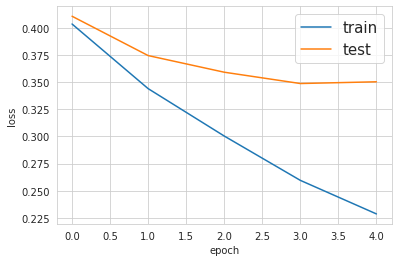

processed 12836 tokens with 537 phrases; found: 269 phrases; correct: 82.

precision:  30.48%; recall:  15.27%; F1:  20.35




Epoch 6 of 50 
Train Loss = 0.18711786790364787
Val Loss = 0.34741141610869647



Epoch 7 of 50 
Train Loss = 0.1590963462834643
Val Loss = 0.35071901985687726



Epoch 8 of 50 
Train Loss = 0.12690690119520784
Val Loss = 0.3621463144795768



Epoch 9 of 50 
Train Loss = 0.11013496340079877
Val Loss = 0.37595246040445646



Epoch 10 of 50 
Train Loss = 0.09059745707490423
Val Loss = 0.39099306754342067


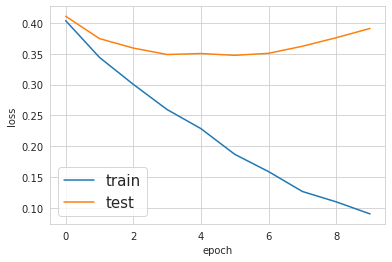

processed 12836 tokens with 537 phrases; found: 345 phrases; correct: 135.

precision:  39.13%; recall:  25.14%; F1:  30.61




Epoch 11 of 50 
Train Loss = 0.06596328886614923
Val Loss = 0.3961887381747827



Epoch 12 of 50 
Train Loss = 0.053390706127361895
Val Loss = 0.4008072453574841



Epoch 13 of 50 
Train Loss = 0.04217473529875712
Val Loss = 0.43749210342264955



Epoch 14 of 50 
Train Loss = 0.033303634612230425
Val Loss = 0.4319555076515712



Epoch 15 of 50 
Train Loss = 0.024312787821163327
Val Loss = 0.4238282221890443


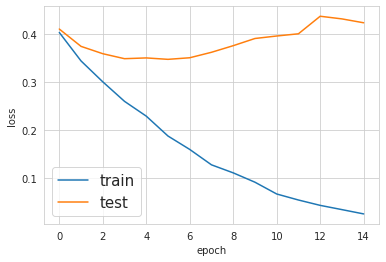

processed 12836 tokens with 537 phrases; found: 441 phrases; correct: 162.

precision:  36.73%; recall:  30.17%; F1:  33.13




Epoch 16 of 50 
Train Loss = 0.021230893951656754
Val Loss = 0.4226809443479336



Epoch 17 of 50 
Train Loss = 0.01796221331310009
Val Loss = 0.4334320012107668



Epoch 18 of 50 
Train Loss = 0.017276401338998403
Val Loss = 0.4371192359366103



Epoch 19 of 50 
Train Loss = 0.013962843075081376
Val Loss = 0.4416629453497806



Epoch 20 of 50 
Train Loss = 0.010805841671714111
Val Loss = 0.4513550340877327


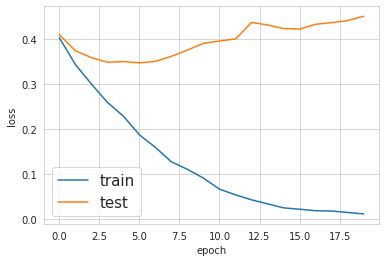

processed 12836 tokens with 537 phrases; found: 412 phrases; correct: 176.

precision:  42.72%; recall:  32.77%; F1:  37.09




Epoch 21 of 50 
Train Loss = 0.010101768622451301
Val Loss = 0.4492141348697053



Epoch 22 of 50 
Train Loss = 0.010952455919913319
Val Loss = 0.45529374022746344



Epoch 23 of 50 
Train Loss = 0.011634258757035325
Val Loss = 0.4913250097159044



Epoch 24 of 50 
Train Loss = 0.009396212152937015
Val Loss = 0.4858302984349707



Epoch 25 of 50 
Train Loss = 0.010152563572105417
Val Loss = 0.43502480149718464


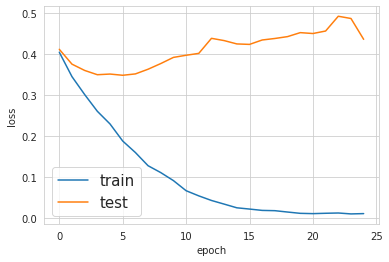

processed 12836 tokens with 537 phrases; found: 408 phrases; correct: 188.

precision:  46.08%; recall:  35.01%; F1:  39.79




Epoch 26 of 50 
Train Loss = 0.010937040199745883
Val Loss = 0.4496856618902005



Epoch 27 of 50 
Train Loss = 0.008244047977114588
Val Loss = 0.4653456341158687



Epoch 28 of 50 
Train Loss = 0.007540186760146021
Val Loss = 0.4511215281161191



Epoch 29 of 50 
Train Loss = 0.009844755474897812
Val Loss = 0.4537199533955918



Epoch 30 of 50 
Train Loss = 0.008931775406492388
Val Loss = 0.4673545982589925


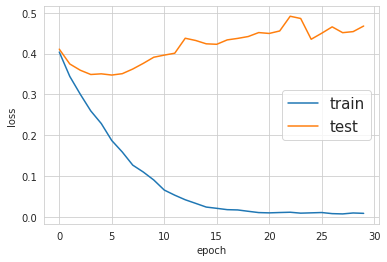

processed 12836 tokens with 537 phrases; found: 365 phrases; correct: 177.

precision:  48.49%; recall:  32.96%; F1:  39.25




Epoch 31 of 50 
Train Loss = 0.004547226829576078
Val Loss = 0.46645380871040226



Epoch 32 of 50 
Train Loss = 0.0031130297186145127
Val Loss = 0.47026898182841415



Epoch 33 of 50 
Train Loss = 0.0025393689724335987
Val Loss = 0.4812745048673615



Epoch 34 of 50 
Train Loss = 0.0022207944291905046
Val Loss = 0.487421235613312



Epoch 35 of 50 
Train Loss = 0.0019325580897104405
Val Loss = 0.4937364909921576


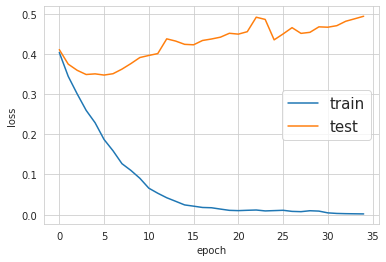

processed 12836 tokens with 537 phrases; found: 337 phrases; correct: 183.

precision:  54.30%; recall:  34.08%; F1:  41.88




Epoch 36 of 50 
Train Loss = 0.001807215807038241
Val Loss = 0.5035328833928776



Epoch 37 of 50 
Train Loss = 0.0017322276096382431
Val Loss = 0.5027431518506212



Epoch 38 of 50 
Train Loss = 0.0016754444674334345
Val Loss = 0.5077489771518658



Epoch 39 of 50 
Train Loss = 0.0015949104607444684
Val Loss = 0.5083767762938504



Epoch 40 of 50 
Train Loss = 0.0015425974349261597
Val Loss = 0.5100047904823974


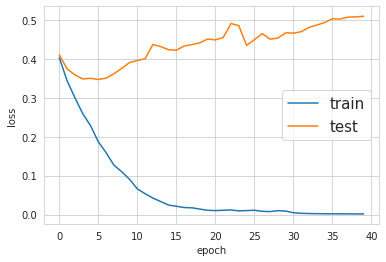

processed 12836 tokens with 537 phrases; found: 342 phrases; correct: 186.

precision:  54.39%; recall:  34.64%; F1:  42.32




Epoch 41 of 50 
Train Loss = 0.0016166673198651986
Val Loss = 0.5125256732754645



Epoch 42 of 50 
Train Loss = 0.0015769257861080494
Val Loss = 0.515010925639762



Epoch 43 of 50 
Train Loss = 0.001532080861538137
Val Loss = 0.5128857905218002



Epoch 44 of 50 
Train Loss = 0.001461919783078933
Val Loss = 0.511221227866822



Epoch 45 of 50 
Train Loss = 0.001564123963676386
Val Loss = 0.525896661993552


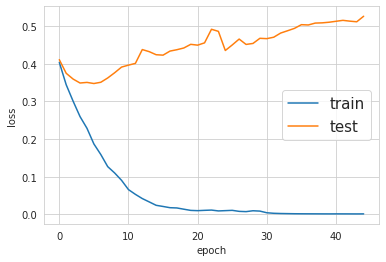

processed 12836 tokens with 537 phrases; found: 336 phrases; correct: 187.

precision:  55.65%; recall:  34.82%; F1:  42.84




Epoch 46 of 50 
Train Loss = 0.0015584875585146637
Val Loss = 0.5211195766246636



Epoch 47 of 50 
Train Loss = 0.0015472744166961318
Val Loss = 0.5302632925617732



Epoch 48 of 50 
Train Loss = 0.0014935657032098472
Val Loss = 0.5213381464123971



Epoch 49 of 50 
Train Loss = 0.0014916615679654713
Val Loss = 0.5246832662805855



Epoch 50 of 50 
Train Loss = 0.0016794345662511272
Val Loss = 0.5318231018631882


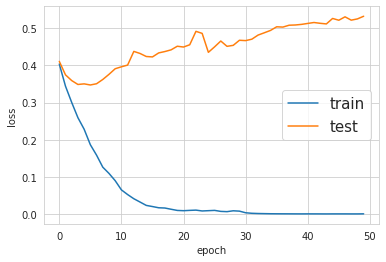

processed 12836 tokens with 537 phrases; found: 348 phrases; correct: 183.

precision:  52.59%; recall:  34.08%; F1:  41.36



In [ ]:
for epoch in range(n_epochs):
    for (x_batch, y_batch) in tqdm(train_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
        train_step(model, x_batch, y_batch, optimizer_ft, loss_func, device, 
                   token_to_idx['<PAD>'])
        # train_acc_on_epoch += get_accuracy(model, x_batch, y_batch, device)
    
    train_loss_on_epoch = 0
    for (x_batch, y_batch) in tqdm(train_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
         train_loss_on_epoch += get_loss(model, x_batch, y_batch, loss_func, device,
                                       token_to_idx['<PAD>'])
        
    val_loss_on_epoch = 0
    for (x_batch, y_batch) in tqdm(val_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
        val_loss_on_epoch += get_loss(model, x_batch, y_batch, loss_func, device,
                                       token_to_idx['<PAD>'])
        # test_acc_on_epoch += get_accuracy(model, x_batch, y_batch, device)

    train_loss_on_epoch /= len(train_loader)
    train_loss_plot.append(train_loss_on_epoch)
    val_loss_on_epoch /= len(val_loader)
    val_loss_plot.append(val_loss_on_epoch)
 
    print('Epoch {} '.format(epoch + 1) + 'of {} '.format(n_epochs) +
          '\nTrain Loss = {}'.format(train_loss_on_epoch) +
          '\nVal Loss = {}'.format(val_loss_on_epoch)
          )

    #lr = learning_rate / learning_rate_decay
    exp_lr_scheduler.step()

    if (epoch + 1) % check_state_after == 0:
        plt.plot(range(len(train_loss_plot)), train_loss_plot, label='train')
        plt.plot(range(len(train_loss_plot)), val_loss_plot, label='test') 
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc="best", prop={'size': 15})
        plt.show()

        evaluator.eval_conll(model, val_loader, print_results=True, short_report=True)
        torch.save(model.state_dict(), './try/Model_'+str(epoch + 1)+'.pth')


Из моделей выше на разных эпохах при оптимальных гиперпараметрах выбмрается та, которая показывает лучшее качество на validation. Ниже сеть с более высоким коэффициентом регуляризации для борьбы с переобучением, но при этом качество на validation ухудшается.  

In [ ]:
check_state_after = 5
n_epochs = 10 * check_state_after

batch_size = 32
learning_rate = 0.001
# learning_rate = 0.001
# learning_rate_decay = 1.3
model = BiLSTMModel(embedding_dim=150,
                    lstm_hidden_size=150,
                    # dropout_zeroed_probability=0.7,
                    dropout_zeroed_probability=0.8,
                    pad_token_idx=token_to_idx['<PAD>'],
                    vocabulary_size=vocab_size,
                    tag_space_size=n_tags)
model.to(device)

loss_func = nn.CrossEntropyLoss().to(device)
lr = learning_rate
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, 
                          weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

train_loss_plot, val_loss_plot = [], []


Epoch 1 of 50 
Train Loss = 0.4102224939777663
Val Loss = 0.4240769636138723



Epoch 2 of 50 
Train Loss = 0.36678919981279545
Val Loss = 0.3914685444891882



Epoch 3 of 50 
Train Loss = 0.34423380891013705
Val Loss = 0.3854035452511213



Epoch 4 of 50 
Train Loss = 0.33190987066993954
Val Loss = 0.3788776610075407



Epoch 5 of 50 
Train Loss = 0.3198736593350879
Val Loss = 0.3760864193191384


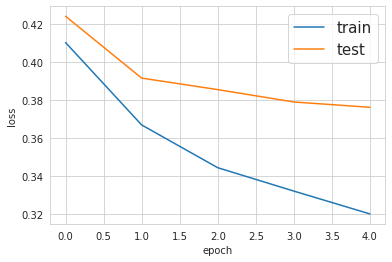

processed 12836 tokens with 537 phrases; found: 63 phrases; correct: 11.

precision:  17.46%; recall:  2.05%; F1:  3.67




Epoch 6 of 50 
Train Loss = 0.3052071893008792
Val Loss = 0.3656980847592211



Epoch 7 of 50 
Train Loss = 0.3001898057861773
Val Loss = 0.36774502153653404



Epoch 8 of 50 
Train Loss = 0.29147677935836713
Val Loss = 0.3620930500253369



Epoch 9 of 50 
Train Loss = 0.27496233562605943
Val Loss = 0.3501951348024106



Epoch 10 of 50 
Train Loss = 0.26903464957843265
Val Loss = 0.353570243871258


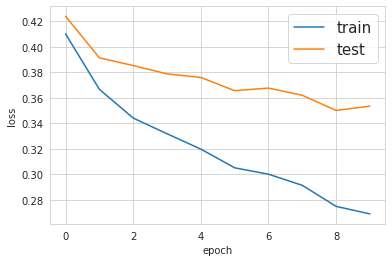

processed 12836 tokens with 537 phrases; found: 173 phrases; correct: 45.

precision:  26.01%; recall:  8.38%; F1:  12.68




Epoch 11 of 50 
Train Loss = 0.25165799083832713
Val Loss = 0.3444032816040722



Epoch 12 of 50 
Train Loss = 0.23099465885156079
Val Loss = 0.33795319325979223



Epoch 13 of 50 
Train Loss = 0.21034802735256866
Val Loss = 0.33958694088890984



Epoch 14 of 50 
Train Loss = 0.19251086545512683
Val Loss = 0.3354608708791426



Epoch 15 of 50 
Train Loss = 0.17453027992224576
Val Loss = 0.3316365326559685


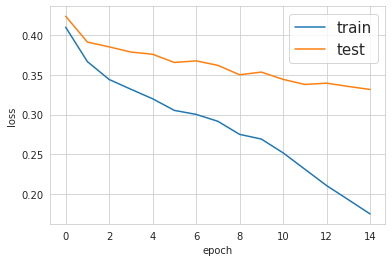

processed 12836 tokens with 537 phrases; found: 361 phrases; correct: 97.

precision:  26.87%; recall:  18.06%; F1:  21.60




Epoch 16 of 50 
Train Loss = 0.15083501530612006
Val Loss = 0.32898026933160945



Epoch 17 of 50 
Train Loss = 0.13277807717032802
Val Loss = 0.32373511709455877



Epoch 18 of 50 
Train Loss = 0.11933806425264565
Val Loss = 0.31883816970525786



Epoch 19 of 50 
Train Loss = 0.10736601143890585
Val Loss = 0.3142492060189513



Epoch 20 of 50 
Train Loss = 0.08912426651797348
Val Loss = 0.3044829086258294


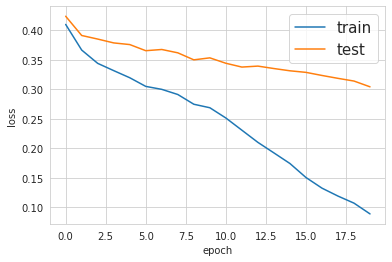

processed 12836 tokens with 537 phrases; found: 385 phrases; correct: 138.

precision:  35.84%; recall:  25.70%; F1:  29.93




Epoch 21 of 50 
Train Loss = 0.08502682407001495
Val Loss = 0.31559333841542886



Epoch 22 of 50 
Train Loss = 0.0746916875526783
Val Loss = 0.3079693896061461



Epoch 23 of 50 
Train Loss = 0.06913965887961424
Val Loss = 0.2990649862198984



Epoch 24 of 50 
Train Loss = 0.0637256709671459
Val Loss = 0.31455178407463263



Epoch 25 of 50 
Train Loss = 0.05985124856125146
Val Loss = 0.30595378329491324


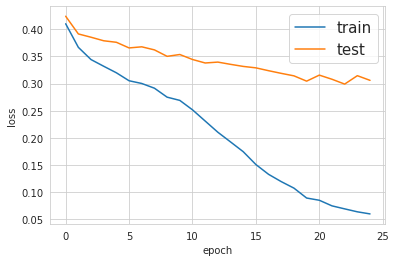

processed 12836 tokens with 537 phrases; found: 378 phrases; correct: 169.

precision:  44.71%; recall:  31.47%; F1:  36.94




Epoch 26 of 50 
Train Loss = 0.05734555100521371
Val Loss = 0.32105878758223527



Epoch 27 of 50 
Train Loss = 0.05473830966593382
Val Loss = 0.33125175450574906



Epoch 28 of 50 
Train Loss = 0.05286211581361172
Val Loss = 0.31275477854806466



Epoch 29 of 50 
Train Loss = 0.05315812318425733
Val Loss = 0.31822700069847215



Epoch 30 of 50 
Train Loss = 0.05266157562721009
Val Loss = 0.31435061948967846


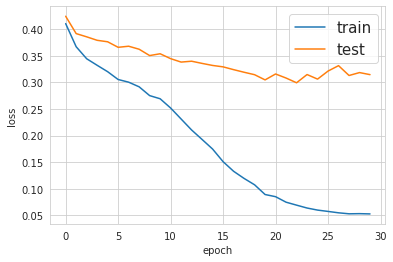

processed 12836 tokens with 537 phrases; found: 378 phrases; correct: 172.

precision:  45.50%; recall:  32.03%; F1:  37.60




Epoch 31 of 50 
Train Loss = 0.04167086874889553
Val Loss = 0.3221073925443873



Epoch 32 of 50 
Train Loss = 0.03796953232237252
Val Loss = 0.3210254778405683



Epoch 33 of 50 
Train Loss = 0.03654491972789987
Val Loss = 0.3204503207512109



Epoch 34 of 50 
Train Loss = 0.034055167692448075
Val Loss = 0.32675807570155224



Epoch 35 of 50 
Train Loss = 0.03263265169666933
Val Loss = 0.32384774844562725


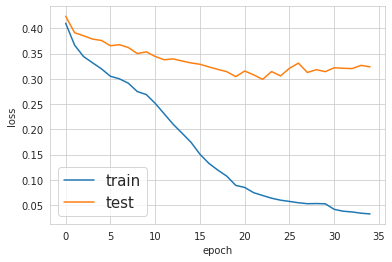

processed 12836 tokens with 537 phrases; found: 330 phrases; correct: 165.

precision:  50.00%; recall:  30.73%; F1:  38.06




Epoch 36 of 50 
Train Loss = 0.03199189762997192
Val Loss = 0.3268892072925699



Epoch 37 of 50 
Train Loss = 0.03127842863764596
Val Loss = 0.3267530849334975



Epoch 38 of 50 
Train Loss = 0.03106901055686599
Val Loss = 0.33246040109977304



Epoch 39 of 50 
Train Loss = 0.030227804960744314
Val Loss = 0.3326202978339866



Epoch 40 of 50 
Train Loss = 0.029884245123129045
Val Loss = 0.3319346372513614


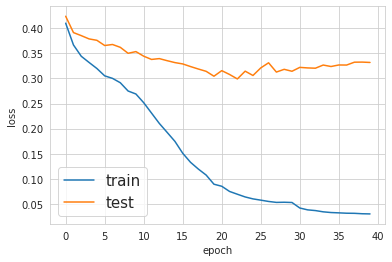

processed 12836 tokens with 537 phrases; found: 333 phrases; correct: 162.

precision:  48.65%; recall:  30.17%; F1:  37.24




Epoch 41 of 50 
Train Loss = 0.029595770146553343
Val Loss = 0.3371315427426451



Epoch 42 of 50 
Train Loss = 0.029730023724394733
Val Loss = 0.33917478728599937



Epoch 43 of 50 
Train Loss = 0.029282838935876288
Val Loss = 0.33918497500194345



Epoch 44 of 50 
Train Loss = 0.02911601726729558
Val Loss = 0.34310892964735595



Epoch 45 of 50 
Train Loss = 0.02871135804403105
Val Loss = 0.3350233279120459


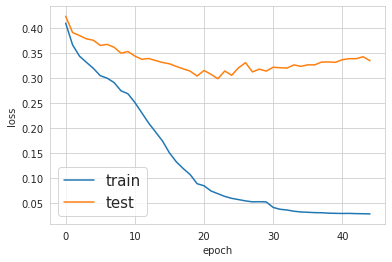

processed 12836 tokens with 537 phrases; found: 347 phrases; correct: 157.

precision:  45.24%; recall:  29.24%; F1:  35.52




Epoch 46 of 50 
Train Loss = 0.028493498708096816
Val Loss = 0.343643303162708



Epoch 47 of 50 
Train Loss = 0.028478317211370528
Val Loss = 0.34364259652783863



Epoch 48 of 50 
Train Loss = 0.02935219180525618
Val Loss = 0.34274568104144665



Epoch 49 of 50 
Train Loss = 0.02793055336450359
Val Loss = 0.34560237846808617



Epoch 50 of 50 
Train Loss = 0.028010142185700145
Val Loss = 0.3490339120292773


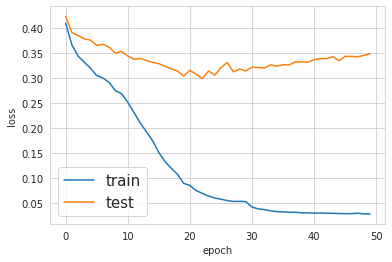

processed 12836 tokens with 537 phrases; found: 334 phrases; correct: 159.

precision:  47.60%; recall:  29.61%; F1:  36.51



In [ ]:
for epoch in range(n_epochs):
    for (x_batch, y_batch) in tqdm(train_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
        train_step(model, x_batch, y_batch, optimizer_ft, loss_func, device, 
                   token_to_idx['<PAD>'])
        # train_acc_on_epoch += get_accuracy(model, x_batch, y_batch, device)
    
    train_loss_on_epoch = 0
    for (x_batch, y_batch) in tqdm(train_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
         train_loss_on_epoch += get_loss(model, x_batch, y_batch, loss_func, device,
                                       token_to_idx['<PAD>'])
        
    val_loss_on_epoch = 0
    for (x_batch, y_batch) in tqdm(val_loader):
        # print(x_batch.shape)
        # print(y_batch.shape)
        val_loss_on_epoch += get_loss(model, x_batch, y_batch, loss_func, device,
                                       token_to_idx['<PAD>'])
        # test_acc_on_epoch += get_accuracy(model, x_batch, y_batch, device)

    train_loss_on_epoch /= len(train_loader)
    train_loss_plot.append(train_loss_on_epoch)
    val_loss_on_epoch /= len(val_loader)
    val_loss_plot.append(val_loss_on_epoch)
 
    print('Epoch {} '.format(epoch + 1) + 'of {} '.format(n_epochs) +
          '\nTrain Loss = {}'.format(train_loss_on_epoch) +
          '\nVal Loss = {}'.format(val_loss_on_epoch)
          )

    #lr = learning_rate / learning_rate_decay
    exp_lr_scheduler.step()

    if (epoch + 1) % check_state_after == 0:
        plt.plot(range(len(train_loss_plot)), train_loss_plot, label='train')
        plt.plot(range(len(train_loss_plot)), val_loss_plot, label='test') 
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc="best", prop={'size': 15})
        plt.show()

        evaluator.eval_conll(model, val_loader, print_results=True, short_report=True)
        torch.save(model.state_dict(), './try_2/Model_'+str(epoch + 1)+'.pth')

В итоге, использована модель из предыдушего опыта, сооттветствующая 45 эпохе. Для нее получены следующие метрики: 

In [ ]:
model = BiLSTMModel(embedding_dim=150,
                    lstm_hidden_size=150,
                    # dropout_zeroed_probability=0.7,
                    dropout_zeroed_probability=0.8,
                    pad_token_idx=token_to_idx['<PAD>'],
                    vocabulary_size=vocab_size,
                    tag_space_size=n_tags)
model.to(device)
model.load_state_dict(torch.load('./try/Model_45.pth'))

<All keys matched successfully>

In [ ]:
evaluator.eval_conll(model, val_loader, print_results=True, short_report=True)

processed 12836 tokens with 537 phrases; found: 336 phrases; correct: 187.

precision:  55.65%; recall:  34.82%; F1:  42.84



{'f1': 42.84077892325315,
 'n_predicted_entities': 336,
 'n_true_entities': 537,
 'precision': 55.654761904761905,
 'recall': 34.82309124767225}

In [ ]:
evaluator.eval_conll(model, test_loader, print_results=True, short_report=True)

processed 13258 tokens with 604 phrases; found: 411 phrases; correct: 233.

precision:  56.69%; recall:  38.58%; F1:  45.91



{'f1': 45.91133004926108,
 'n_predicted_entities': 411,
 'n_true_entities': 604,
 'precision': 56.69099756690998,
 'recall': 38.57615894039735}

##Отчет:
Данное качество тэггинга получено без использования тестовой выборки путем экспериментирования -  вручную был проделанан grid search по гиперпараметрам в интервалах, предложенных авторами (то есть я перебирал значения lr, dropout, batch size и размеры слоев - эмбеддинга и lstm). 

После уменьшения batch size (пробовал 100, 200) и увеличения dropout (вышел из предложенного интервала) F1 метрика все еще не перевалила за порог 35%. При этом переобучения не наблюдалось - лосс на валидации на протяжении всего обучения существенно не удалялся от лосса на трейне. Далее был увеличен lr с 0.0001 до 0.001, но также был добавлено уменьшение его в 10 раз каждые 30 эпох, что увеличило f1 - он стал больше 0.35. При этом лосс на трейне намного сильнее стал приближаться к нулю (на мой взгляд именно этот момент был важен для повышения качества, раньше этого не было из-за малого шага в градиентном спуске. При этом лосс на валидации примерно через пять эпох стал повышаться. Для борьбы с возникшим переобучением была использована l2 регуляризация в оптимизации. Вначале был выбран коэффициент 0.1, из-за чего лоссы перестали приближаться к нулю, при этом качетво f1 на валидации худшилось. Уменьшая этот к-нт регуляризации в 10 раз был найден условно оптималььный, при котором лосс на валидации уже не рос почти до 1 как раньше, но сохранялся примерно на уровне инициализации. В итоге, сеть, результаты которой показаны выше на тесте и валидации (больше 40%), переобучена, но качество показывает лучшее по сравнению с более ругуляризованной версией. Насколько я заметил, модель чувствительнее всего к размерам шага оптимизации и коэффициента регуляризации, поскольку от них больше всего зависело, насколько близко лосс на трейне приблизится к нулю. Сложилось такое впечатление, что от значения последнего зависит итоговое качетсво (а от значения лосса на валидации не очень).      

## Необучаемый пост-процессинг результата (4 балла).

Для обучения нейросетевой модели разметки используется поэлементная кросс-энтропия. При использовании на этапе инференса функции $\arg \max$ для получения выходной последовательности, мы не можем гарантировать согласованность предсказаний. Для согласованности необходимо вместо $\arg \max$ использовать другие функции получения предсказаний.

В модели CRF для получения предсказаний используется алгоритм Витерби. Напомним, что модель CRF моделирует вероятность последовательности $y$ при условии $x$ линейной моделью с вектором весов $w \in \mathbb{R}^d$, которая после некоторых преобразований записывается следующим образом:
$$
p(y|x, w) = \frac{1}{Z(x, w)} \exp\left( \sum_{i=1}^n \sum_{j = 1}^d w_j f_j(y_{i-1}, y_i, x_i, i) \right) =  \frac{1}{Z(x, w)} \exp\left( \sum_{i=1}^n G_{x, i}[y_{i-1}, y_i] \right)
$$

Модель необучаемого пост-процессинга **подробно описана** в приложении к заданию. Она сводится к следующим шагам.

1. Реализовать модель CRF с двумя признаками:
    
    * Лог-софтмакс выходов модели (выход, соответствующий $y_i$ тэгу для i-го токена будем обозначать $S_{i,y_i}$)    
    
    $$
    f_1(y_{i-1}, y_i, x_i, i) = S_{i,y_i}
    $$
    
    * Логарифмы вероятностей переходов

    $$
    f_2(y_{i-1}, y_i, x_i, i) = \log A[v=y_{i}, u=y_{i-1}] \mathbb{I}[i > 1] \times \log C[v = y_i] \mathbb{I}[i = 1], \quad \text{где:}
    $$

    $$A_{vu} = \frac{\sum_{y}\sum_{i=2}^{|y|} \mathbb{I}[y_{i} = v, y_{i - 1} = u]}{\sum_{y}\sum_{i=2}^{|y|} \mathbb{I}[y_{i-1} = u]}
    $$
    $$
    C_v = \frac{\sum_{y}\mathbb{I}[y_{1} = v]}{\sum_{y}1}
    $$
    
2. Реализовать процедуру получения оптимальной выходной последовательности, используя алгоритм Витерби

3. Подобрать на валидационной выборке веса модели $w_1$ и $w_2$

Для исходной модели, дающей на валидационной и тестовой выборке F1 меру 0.408 и 0.46 соответственно, качество после такого пост-процессинга выросло до 0.461 и 0.493. Заметим, что для тестирования модели не нужно переобучать исходную модель. Для более устойчивого поведения модели, используйте сглаживание матрицы $A$ (добавьте перед нормировкой ко всем значениям одинаковое небольшое число).

**<font color='red'>Задание. Реализуйте требуемую модель, добейтесь улучшения качества на валидации и тесте, сделайте выводы.</font>**

In [ ]:
class ViterbiPostprocesser:    
    def __init__(self, model, smoothing=1.0, w=1.0):
        """
        model : torch.nn.Module
            Tagging model
        smoothing : float, constant in add-k-smoothing
        w : feature weight
             Use w for first feature weight and (1 - w) for second feature.
        """
        self.model = model
        self.smoothing = smoothing
        self.w = w
        self.device = self.model.device
        
    def fit(self, dataset):
        """
        Fit the model using maximum likelihood method.
        
        dataset: torch.dataset
            One element if pair (sentence, tags) 
       """     
        tags = set()
        for inputs, labels in dataset:
            for label in labels:
                tags.add(label.item())
        self.n_tags = len(tags)
        N = len(dataset)
        
        C = torch.tensor([torch.sum(dataset[i][1][0] == v).item()/N for i in range(N) for v in range(self.n_tags)])
        C = torch.log(C+self.smoothing).to(self.device)
        self.C = C

        A = torch.zeros((self.n_tags, self.n_tags))
        for u in tqdm(range(self.n_tags)):
            denominator = sum([torch.sum(dataset[i][1][:-1] == u).item() for i in range(N)])
            
            for v in range(self.n_tags):
                numerator = sum([torch.sum((dataset[i][1][1:] == v)*(dataset[i][1][:-1]==u)).item() for i in range(N)])
                A[v][u] = torch.log(torch.tensor((numerator+self.smoothing)/(denominator+self.smoothing * self.n_tags)))
        self.A = A.to(self.device)

    def decode(self, model_logprobs):
        """
        Viterbi decoding for input model output
        
        model_logprobs : torch.tensor
            Shape is (sequence_length, tag_space_size) 
        """
        N, M = model_logprobs.shape[0], model_logprobs.shape[1] 

        delta = torch.zeros((M, N)).to(self.device)
        s = torch.zeros((M,N)).to(self.device)
        for i in range(M):
            delta[i][0] = model_logprobs[0][i] + self.C[i]          
        for i in range(1, N):
            for j in range(M):
                temp = delta[:,i-1] + (1-self.w)*self.A[j,:] + self.w*model_logprobs[i][j]
                delta[j][i] = torch.max(temp)
                s[j][i] = torch.argmax(temp)
        S = torch.zeros(N).type(torch.int).to(self.device)
        S[N-1] = torch.argmax(delta[:,M-1])

        for j in range(N-2,-1,-1):
            S[j] = s[S[j+1],j+1]
        return S
    
    def predict_for_batch(self, x_batch):
        """
        Returns predictions for x_batch. Use viterbi decoding.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        """
        self.model.eval()
        pred_indeces_of_tag = torch.LongTensor(x_batch.shape)
        log_probabilities = F.log_softmax(self.model(x_batch.to(self.device)), dim=2)
        with torch.no_grad():
            for i in tqdm(range(len(log_probabilities))):
                log_prob = log_probabilities[i]
                pred_indeces_of_tag[i] = self.decode(log_prob.to(self.device))
        return pred_indeces_of_tag      

Место для ваших экспериментов:

Первая (лучшая модель)

In [ ]:
model = BiLSTMModel(embedding_dim=150,
                    lstm_hidden_size=150,
                    # dropout_zeroed_probability=0.7,
                    dropout_zeroed_probability=0.8,
                    pad_token_idx=token_to_idx['<PAD>'],
                    vocabulary_size=vocab_size,
                    tag_space_size=n_tags)
model.to(device)
model.load_state_dict(torch.load('./try/Model_45.pth'))

<All keys matched successfully>

Подберем w 

In [ ]:
for i in np.linspace(0.7, 1, 10):
    crf = ViterbiPostprocesser(model, w=i)
    crf.fit(train_dataset)
    evaluator.eval_conll(crf, val_loader, print_results=True, short_report=True)


processed 12836 tokens with 537 phrases; found: 286 phrases; correct: 182.

precision:  63.64%; recall:  33.89%; F1:  44.23




processed 12836 tokens with 537 phrases; found: 289 phrases; correct: 182.

precision:  62.98%; recall:  33.89%; F1:  44.07




processed 12836 tokens with 537 phrases; found: 296 phrases; correct: 185.

precision:  62.50%; recall:  34.45%; F1:  44.42




processed 12836 tokens with 537 phrases; found: 298 phrases; correct: 185.

precision:  62.08%; recall:  34.45%; F1:  44.31




processed 12836 tokens with 537 phrases; found: 303 phrases; correct: 185.

precision:  61.06%; recall:  34.45%; F1:  44.05




processed 12836 tokens with 537 phrases; found: 311 phrases; correct: 188.

precision:  60.45%; recall:  35.01%; F1:  44.34




processed 12836 tokens with 537 phrases; found: 321 phrases; correct: 190.

precision:  59.19%; recall:  35.38%; F1:  44.29




processed 12836 tokens with 537 phrases; found: 326 phrases; correct: 190.

precision:  58.28%; recall:  35.38%; F1:  44.03




processed 12836 tokens with 537 phrases; found: 331 phrases; correct: 190.

precision:  57.40%; recall:  35.38%; F1:  43.78




processed 12836 tokens with 537 phrases; found: 336 phrases; correct: 187.

precision:  55.65%; recall:  34.82%; F1:  42.84



In [ ]:
np.linspace(0.7, 1, 10)

array([0.7       , 0.73333333, 0.76666667, 0.8       , 0.83333333,
       0.86666667, 0.9       , 0.93333333, 0.96666667, 1.        ])

In [ ]:
crf = ViterbiPostprocesser(model, w=np.linspace(0.7, 1, 10)[2])
crf.fit(train_dataset)

In [ ]:
evaluator.eval_conll(crf, val_loader, print_results=True, short_report=True)


processed 12836 tokens with 537 phrases; found: 296 phrases; correct: 185.

precision:  62.50%; recall:  34.45%; F1:  44.42



{'f1': 44.41776710684273,
 'n_predicted_entities': 296,
 'n_true_entities': 537,
 'precision': 62.5,
 'recall': 34.45065176908752}

In [ ]:
evaluator.eval_conll(crf, test_loader, print_results=True, short_report=True)


processed 13258 tokens with 604 phrases; found: 365 phrases; correct: 230.

precision:  63.01%; recall:  38.08%; F1:  47.47



{'f1': 47.47162022703819,
 'n_predicted_entities': 365,
 'n_true_entities': 604,
 'precision': 63.013698630136986,
 'recall': 38.079470198675494}

После подбора параметра w получил следующее улучшение F1:

на валидации 42.84 -> 44.42

на тесте 45.91 -> 47.47